### Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import keras
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from warnings import warn

from PIL import Image

from keras import backend as K
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.layers import Conv2DTranspose
from keras.layers import Activation, Input, Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, History

from scipy.ndimage import uniform_filter, gaussian_filter
from skimage.util.dtype import dtype_range
from skimage.util.arraycrop import crop
from skimage._shared.utils import warn

Using TensorFlow backend.


### Structural Similarity

In [0]:
__all__ = ['structural_similarity']

# Extracted from: https://github.com/scikit-image/scikit-image/blob/master/skimage/_shared/utils.py
def check_shape_equality(im1, im2):
    """Raise an error if the shape do not match."""
    if not im1.shape == im2.shape:
        raise ValueError('Input images must have the same dimensions.')
    return


def structural_similarity(im1, im2,
                          *,
                          win_size=None, gradient=False, data_range=None,
                          multichannel=False, gaussian_weights=False,
                          full=False, **kwargs):
    check_shape_equality(im1, im2)

    if multichannel:
        # loop over channels
        args = dict(win_size=win_size,
                    gradient=gradient,
                    data_range=data_range,
                    multichannel=False,
                    gaussian_weights=gaussian_weights,
                    full=full)
        args.update(kwargs)
        nch = im1.shape[-1]
        mssim = np.empty(nch)
        if gradient:
            G = np.empty(im1.shape)
        if full:
            S = np.empty(im1.shape)
        for ch in range(nch):
            ch_result = structural_similarity(im1[..., ch],
                                              im2[..., ch], **args)
            if gradient and full:
                mssim[..., ch], G[..., ch], S[..., ch] = ch_result
            elif gradient:
                mssim[..., ch], G[..., ch] = ch_result
            elif full:
                mssim[..., ch], S[..., ch] = ch_result
            else:
                mssim[..., ch] = ch_result
        mssim = mssim.mean()
        if gradient and full:
            return mssim, G, S
        elif gradient:
            return mssim, G
        elif full:
            return mssim, S
        else:
            return mssim

    K1 = kwargs.pop('K1', 0.01)
    K2 = kwargs.pop('K2', 0.03)
    sigma = kwargs.pop('sigma', 1.5)
    if K1 < 0:
        raise ValueError("K1 must be positive")
    if K2 < 0:
        raise ValueError("K2 must be positive")
    if sigma < 0:
        raise ValueError("sigma must be positive")
    use_sample_covariance = kwargs.pop('use_sample_covariance', True)

    if gaussian_weights:
        # Set to give an 11-tap filter with the default sigma of 1.5 to match
        # Wang et. al. 2004.
        truncate = 3.5

    if win_size is None:
        if gaussian_weights:
            # set win_size used by crop to match the filter size
            r = int(truncate * sigma + 0.5)  # radius as in ndimage
            win_size = 2 * r + 1
        else:
            win_size = 7   # backwards compatibility

    if np.any((np.asarray(im1.shape) - win_size) < 0):
        raise ValueError(
            "win_size exceeds image extent.  If the input is a multichannel "
            "(color) image, set multichannel=True.")

    if not (win_size % 2 == 1):
        raise ValueError('Window size must be odd.')

    if data_range is None:
        if im1.dtype != im2.dtype:
            warn("Inputs have mismatched dtype.  Setting data_range based on "
                 "im1.dtype.", stacklevel=2)
        dmin, dmax = dtype_range[im1.dtype.type]
        data_range = dmax - dmin

    ndim = im1.ndim

    if gaussian_weights:
        filter_func = gaussian_filter
        filter_args = {'sigma': sigma, 'truncate': truncate}
    else:
        filter_func = uniform_filter
        filter_args = {'size': win_size}

    # ndimage filters need floating point data
    im1 = im1.astype(np.float64)
    im2 = im2.astype(np.float64)

    NP = win_size ** ndim

    # filter has already normalized by NP
    if use_sample_covariance:
        cov_norm = NP / (NP - 1)  # sample covariance
    else:
        cov_norm = 1.0  # population covariance to match Wang et. al. 2004

    # compute (weighted) means
    ux = filter_func(im1, **filter_args)
    uy = filter_func(im2, **filter_args)

    # compute (weighted) variances and covariances
    uxx = filter_func(im1 * im1, **filter_args)
    uyy = filter_func(im2 * im2, **filter_args)
    uxy = filter_func(im1 * im2, **filter_args)
    vx = cov_norm * (uxx - ux * ux)
    vy = cov_norm * (uyy - uy * uy)
    vxy = cov_norm * (uxy - ux * uy)

    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2

    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    D = B1 * B2
    S = (A1 * A2) / D

    # to avoid edge effects will ignore filter radius strip around edges
    pad = (win_size - 1) // 2

    # compute (weighted) mean of ssim
    mssim = crop(S, pad).mean()

    if gradient:
        # The following is Eqs. 7-8 of Avanaki 2009.
        grad = filter_func(A1 / D, **filter_args) * im1
        grad += filter_func(-S / B2, **filter_args) * im2
        grad += filter_func((ux * (A2 - A1) - uy * (B2 - B1) * S) / D,
                            **filter_args)
        grad *= (2 / im1.size)

        if full:
            return mssim, grad, S
        else:
            return mssim, grad
    else:
        if full:
            return mssim, S
        else:
            return mssim

### Load Dataset

In [3]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


### Keras Classifier

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10
input_shape = (1, img_rows, img_cols) if K.image_data_format() == 'channels_first' else (img_rows, img_cols, 1)

classifier = Sequential([
    Conv2D(32, 5, activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(64, 5, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(600, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

def main():
    batch_size = 64
    epochs = 100

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

    # Scale to [0, 1]
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    # Normalize
    mean = 0.1307
    std = 0.3081
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    classifier.summary()

    checkpoint = ModelCheckpoint('mnist_cnn.h5',
                                 verbose=1, save_best_only=True, save_weights_only=True)

    classifier.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.5),
                  metrics=['accuracy'])

    classifier.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=[checkpoint],
              validation_data=(x_test, y_test))
    score = classifier.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])


if __name__ == '__main__':
    main()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
___________________________________________________________

### Image Corruption

In [0]:
def corrupt_mnist_img(rng, img, value):
    # Choose square size
    s = rng.randint(7, 15)
    # Choose top-left corner position
    x = rng.randint(0, 29 - s)
    y = rng.randint(0, 29 - s)
    # Draw square
    img[..., y:y + s, x:x + s] = value
    # Return object for convenience
    return img


def corrupt_mnist_copy(x_train, value=255, seed=0):
    rng = np.random.RandomState(seed)
    corrupted_x_train = x_train.copy()
    for img in corrupted_x_train:
        corrupt_mnist_img(rng, img, value)
    return corrupted_x_train

### Benchmark Code

In [0]:
class IdentityModel(keras.Model):

    def __init__(self):
        super().__init__()
        self.identity = keras.layers.Lambda(lambda x: x)

    def call(self, x):
        return self.identity(x)


def _preprocess_for_classifier(x):
    return (x - 0.1307) / 0.3081


def test_model(model, x_test, y_test, batch_size=100):
    rng = np.random.RandomState(0)

    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
    # classifier.load_weights('mnist_cnn.h5', by_name=True)

    baseline_score = 0
    correct_score = 0
    ssim_score = 0

    N = len(x_test)
    assert N % batch_size == 0, 'N should be divisible by batch_size'
    num_batches = N // batch_size
    for i in range(num_batches):
        # Shape: (B, 28, 28, 1) or (B, 1, 28, 28) if channels_first
        imgs_orig = np.expand_dims(x_test[batch_size*i:batch_size*(i + 1)], channel_dim)
        # Shape: (B,)
        labels = y_test[batch_size*i:batch_size*(i + 1)]

        # Create corruption masks
        masks = []
        for _ in range(batch_size):
            # Choose square size
            s = rng.randint(7, 15)
            # Choose top-left corner position
            x = rng.randint(0, 29 - s)
            y = rng.randint(0, 29 - s)
            mask = np.zeros(imgs_orig.shape[1:], dtype=np.bool)
            # Set mask area
            mask[y:y + s, x:x + s, :] = True
            masks.append(mask)
        masks = np.stack(masks)

        imgs_corrupted = imgs_orig.copy()
        # Draw squares
        imgs_corrupted[masks] = 1.

        # Generate restored images
        imgs_restored = model.predict_on_batch(imgs_corrupted)

        predicted_labels_orig = classifier.predict_on_batch(_preprocess_for_classifier(imgs_orig)).argmax(axis=-1)
        predicted_labels_restored = classifier.predict_on_batch(_preprocess_for_classifier(imgs_restored)).argmax(axis=-1)
        # Calculate classifier score
        baseline = labels == predicted_labels_orig
        correct = baseline == (labels == predicted_labels_restored)
        baseline_score += int(baseline.sum())
        correct_score += int(correct.sum())

        ssim_score += structural_similarity(imgs_orig[~masks].squeeze(), imgs_restored[~masks].squeeze())

    classifier_score = correct_score / baseline_score
    ssim_score /= num_batches

    print('Classifier score: {:.2f}\nSSIM score: {:.2f}'.format(100 * classifier_score, 100 * ssim_score))

### Reshape Dimensions

In [0]:
image_size = x_train.shape[1]

x_train_start = x_train
x_test_start = x_test
x_train_noisy_start = corrupt_mnist_copy(x_train)
x_test_noisy_start = corrupt_mnist_copy(x_test)
x_test_noisy_reshaped = np.reshape(x_test_noisy_start, [-1, image_size, image_size, 1])
x_test_noisy_reshaped = x_test_noisy_reshaped / 255

In [0]:
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

x_train_noisy = corrupt_mnist_copy(x_train)
x_test_noisy = corrupt_mnist_copy(x_test)

x_train = x_train / 255
x_test = x_test  / 255
x_train_noisy = x_train_noisy / 255
x_test_noisy = x_test_noisy / 255

# 1.   **Data Visualization**



[ORIGINAL DATA]


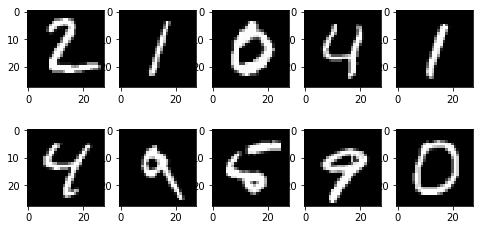

In [9]:
print("[ORIGINAL DATA]")
fig=plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i in range(1, columns*rows + 1):
    img = x_test_start[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

[CORRUPTED DATA]


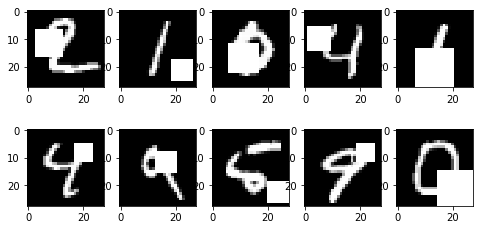

In [10]:
print("[CORRUPTED DATA]")
fig=plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i in range(1, columns*rows + 1):
    img = x_test_noisy_start[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [0]:
# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16

In [0]:
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [0]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [0]:
# Shape info needed to build Decoder Model
shape = K.int_shape(x)

In [0]:
# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [0]:
# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')

In [0]:
# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [0]:
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

In [0]:
# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')

# 2.   **Model Summary**

[TEXT SUMMARY]

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


[IMAGE SUMMARY]



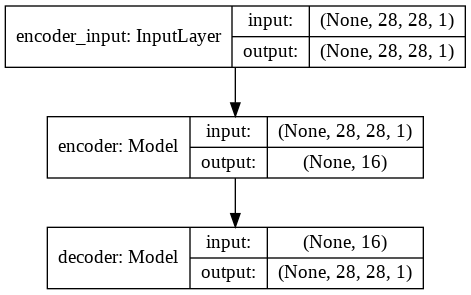

In [20]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

print("[TEXT SUMMARY]\n")
autoencoder.summary()

print("\n\n[IMAGE SUMMARY]\n")
plot_model(autoencoder, to_file = 'AE_mnist.png', show_shapes = True)

In [0]:
# checkpoint = ModelCheckpoint('mnist_cnn.h5',
#                             verbose=0, save_best_only=True, save_weights_only=True)
autoencoder.compile(loss='mse', optimizer='adam')

# 3.  **Plots of losses per epoch**



Training: 5 Epochs
dict_keys(['val_loss', 'loss'])


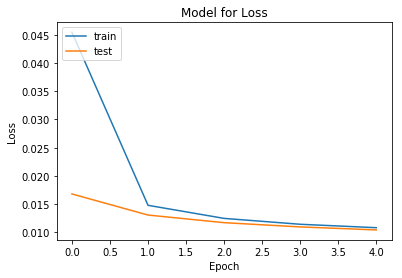

In [22]:
# Train the autoencoder
epochs = 5
history = autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=epochs,
                batch_size=batch_size, verbose=0)

print("Training:" , epochs , "Epochs")
autoencoder.history

# List all data in history
print(history.history.keys())
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model for Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

In [24]:
# Display at least 5 samples for the results
rows, cols = 1, 5
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy_reshaped[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# 4. **Results (5 Samples)**



	 [TOP ROW] Original Images
	 [MIDDLE ROW] Corrupted Images
	 [LAST ROW] Restored Images


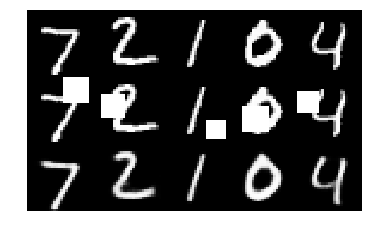

In [25]:
plt.axis('off')
print('\t [TOP ROW] Original Images\n\t [MIDDLE ROW] Corrupted Images\n\t [LAST ROW] Restored Images')
plt.imshow(imgs, interpolation='none', cmap='gray')
# Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

# 5. **Benchmark Output**



In [26]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_test = x_test / 255

test_model(autoencoder, x_test, y_test, batch_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


Classifier score: 58.77
SSIM score: 77.27
